## **Huấn luyện mô hình CNN nhận diện món ăn**

### **1. Import thư viện & Thiết lập tham số**

In [2]:
# Import thư viện
import json
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import random
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print("Đã import các thư viện cần thiết!")

Đã import các thư viện cần thiết!


In [3]:
# Tự động xác định đường dẫn
cwd = Path.cwd()
candidate_dirs = [cwd / 'data', cwd.parent / 'data']
DATA_DIR_REQ = next((p for p in candidate_dirs if p.exists()), candidate_dirs[0])
print('Đường dẫn folder chứa dataset là DATA_DIR:', DATA_DIR_REQ)

# Thiết lập tham số
IMG_SIZE = (128, 128)
BATCH_SIZE_REQ = 32
EPOCHS_REQ = 15
SEED_REQ = 123
AUTOTUNE = tf.data.AUTOTUNE

Đường dẫn folder chứa dataset là DATA_DIR: d:\IR_challenge\data


### **2. Chuẩn bị dữ liệu**

In [4]:
# Thông tin về dataset
image_exts = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.webp'}
class_folders = [d for d in DATA_DIR_REQ.iterdir() if d.is_dir()]
class_counts = {d.name: len([f for f in d.glob('*') if f.suffix.lower() in image_exts]) for d in class_folders}
num_classes = len(class_folders)
total_images = sum(len([f for f in folder.glob('*') if f.suffix.lower() in image_exts]) for folder in class_folders)

print(f"- Đường dẫn: {DATA_DIR_REQ}")
print(f"- Số lượng lớp chứa ảnh: {num_classes}")
print(f"- Tổng số ảnh các lớp: {total_images:,}")
print(f"- Trung bình số ảnh mỗi lớp: {total_images / num_classes:.1f}")
print(f"- Danh sách các lớp: {', '.join(d.name for d in class_folders)}")

- Đường dẫn: d:\IR_challenge\data
- Số lượng lớp chứa ảnh: 21
- Tổng số ảnh các lớp: 25,287
- Trung bình số ảnh mỗi lớp: 1204.1
- Danh sách các lớp: canh_bi_dao, canh_bi_do, canh_chua, canh_cu_qua, canh_khoai_mo, canh_kho_qua, canh_rau_cai, ca_kho, com_trang, dau_hu_sot_ca, do_chua, gio_cha, khay_trong, kho_qua_xao_trung, lac_rang_muoi_vung, lap_xuong, rau, suon_nuong, thit_kho, thit_kho_trung, trung_chien


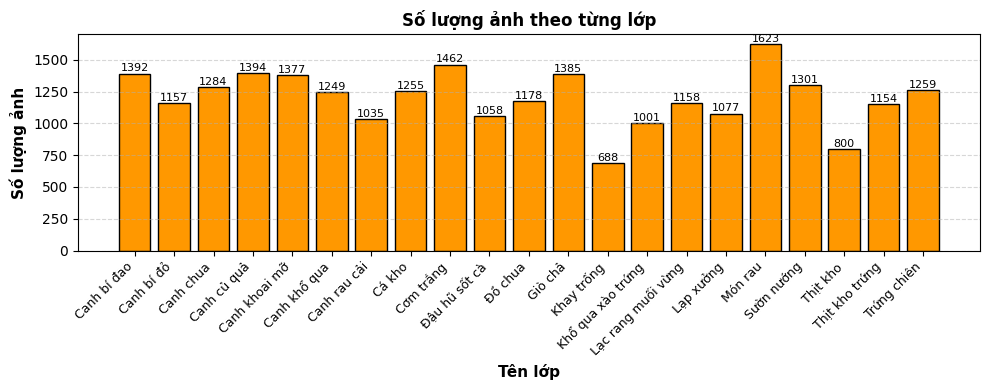

In [5]:
# Từ điển tên món Tiếng Việt
with open("../VN_labels.json", "r", encoding="utf-8") as f:
    VN_labels = json.load(f)

VN_titles = [VN_labels.get(cls, cls.replace('_', ' ')) for cls in class_counts.keys()]

# Trực quan hóa số lượng ảnh mỗi lớp trong dataset
plt.figure(figsize=(10, 4))
plt.bar(VN_titles, class_counts.values(), color='#FF9800', edgecolor='black')

plt.title("Số lượng ảnh theo từng lớp", fontsize=12, fontweight='bold')
plt.xlabel("Tên lớp", fontsize=11, fontweight='bold')
plt.ylabel("Số lượng ảnh", fontsize=11, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.grid(axis='y', linestyle='--', alpha=0.5)

for i, v in enumerate(class_counts.values()):
    plt.text(i, v+1, str(v), ha='center', va='bottom', fontsize=8)

plt.ylim(0, 1700)
plt.tight_layout()
plt.show()

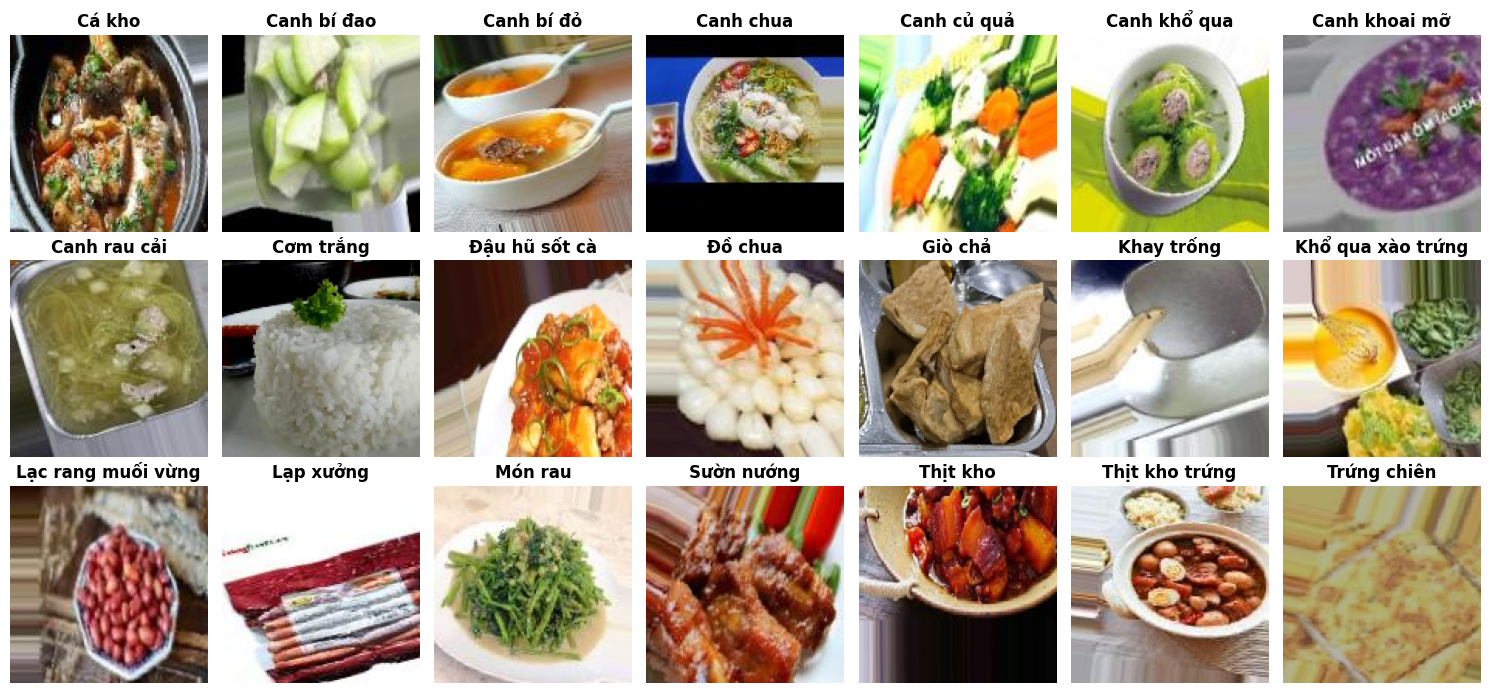

In [8]:
# Hiển thị ngẫu nhiên hình ảnh của 21 lớp
class_folders = sorted([d.name for d in DATA_DIR_REQ.iterdir() if d.is_dir()])
num_classes_display = len(class_folders)
fig, axes = plt.subplots(3, 7, figsize=(15,7))  # 3 hàng x 7 cột
axes = axes.flatten()

# Duyệt từng lớp và hiển thị một ảnh ngẫu nhiên của lớp đó
for i, class_name in enumerate(class_folders):
    class_dir = Path(DATA_DIR_REQ) / class_name
    image_files = [p for p in class_dir.rglob('*') if p.suffix.lower() in {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.webp'}]
    if not image_files:
        continue

    # Lấy ảnh ngẫu nhiên và hiển thị
    img_path = random.choice(image_files)
    img = tf.keras.utils.load_img(img_path, target_size=IMG_SIZE)
    axes[i].imshow(img)
    axes[i].set_title(VN_labels.get(class_name, class_name.replace('_', ' ')), fontweight='bold', fontsize=12)
    axes[i].axis('off')

# Ẩn các ô trống nếu số lớp nhỏ hơn số ô hiển thị
for j in range(num_classes_display, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [9]:
# Chia tập train/val theo tỷ lệ 80/20
train_ds_req = image_dataset_from_directory(DATA_DIR_REQ, validation_split=0.2, subset='training',
                                            seed=SEED_REQ, image_size=IMG_SIZE, batch_size=BATCH_SIZE_REQ, label_mode='int')

val_ds_req = image_dataset_from_directory(DATA_DIR_REQ, validation_split=0.2, subset='validation',
                                          seed=SEED_REQ, image_size=IMG_SIZE, batch_size=BATCH_SIZE_REQ, label_mode='int')

class_names_req = train_ds_req.class_names
num_classes_req = len(class_names_req)
print('Xác định được', num_classes_req, 'lớp:', class_names_req)

# Tối ưu pipeline đọc dữ liệu
train_ds_req = train_ds_req.cache().prefetch(AUTOTUNE)
val_ds_req = val_ds_req.cache().prefetch(AUTOTUNE)

Found 25265 files belonging to 21 classes.
Using 20212 files for training.
Found 25265 files belonging to 21 classes.
Using 5053 files for validation.
Xác định được 21 lớp: ['ca_kho', 'canh_bi_dao', 'canh_bi_do', 'canh_chua', 'canh_cu_qua', 'canh_kho_qua', 'canh_khoai_mo', 'canh_rau_cai', 'com_trang', 'dau_hu_sot_ca', 'do_chua', 'gio_cha', 'khay_trong', 'kho_qua_xao_trung', 'lac_rang_muoi_vung', 'lap_xuong', 'rau', 'suon_nuong', 'thit_kho', 'thit_kho_trung', 'trung_chien']


### **3. Xây dựng và huấn luyện mô hình CNN**

In [10]:
# Xây dựng mô hình CNN
model_req = Sequential([Rescaling(1./255, input_shape=(*IMG_SIZE, 3)),      # Chuẩn hóa giá trị pixel từ [0, 255] → [0, 1]
                        Conv2D(32, 3, activation='relu', padding='same'),   # Tầng tích chập đầu: 32 bộ lọc
                        MaxPooling2D(),                                     # Lấy đặc trưng nổi bật nhất, giảm kích cỡ ảnh
                        Conv2D(64, 3, activation='relu', padding='same'),   # Tầng tích chập hai: 64 bộ lọc
                        MaxPooling2D(),
                        Conv2D(128, 3, activation='relu', padding='same'),  # Tầng tích chập ba: 128 bộ lọc
                        MaxPooling2D(),
                        Flatten(),                                          # Chuyển tensor 3D về vector 1D để đưa vào Dense
                        Dropout(0.5),                                       # Bỏ ngẫu nhiên 50% neuron để tránh overfitting
                        Dense(128, activation='relu'),
                        Dense(num_classes_req, activation='softmax')])      # Tầng đầu ra

# Biên dịch mô hình CNN
model_req.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_req.summary()

c:\Users\ADMIN\miniconda3\envs\IR_challenge\Lib\site-packages\keras\src\layers\preprocessing\data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 21)             │         2,709 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,290,389 (16.37 MB)

 Trainable params: 4,290,389 (16.37 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Huấn luyện mô hình CNN
history_req = model_req.fit(train_ds_req, 
                            validation_data=val_ds_req, 
                            epochs=EPOCHS_REQ, 
                            verbose=1)

Epoch 1/15
632/632 ━━━━━━━━━━━━━━━━━━━━ 358s 560ms/step - accuracy: 0.4153 - loss: 1.7649 - val_accuracy: 0.5533 - val_loss: 1.3173
Epoch 2/15
632/632 ━━━━━━━━━━━━━━━━━━━━ 258s 409ms/step - accuracy: 0.6104 - loss: 1.1632 - val_accuracy: 0.6434 - val_loss: 1.0642
Epoch 3/15
632/632 ━━━━━━━━━━━━━━━━━━━━ 269s 425ms/step - accuracy: 0.7068 - loss: 0.8791 - val_accuracy: 0.6814 - val_loss: 0.9887
Epoch 4/15
632/632 ━━━━━━━━━━━━━━━━━━━━ 265s 419ms/step - accuracy: 0.7743 - loss: 0.6765 - val_accuracy: 0.7004 - val_loss: 0.9454
Epoch 5/15
632/632 ━━━━━━━━━━━━━━━━━━━━ 265s 419ms/step - accuracy: 0.8203 - loss: 0.5365 - val_accuracy: 0.7283 - val_loss: 0.8882
Epoch 6/15
632/632 ━━━━━━━━━━━━━━━━━━━━ 276s 436ms/step - accuracy: 0.8593 - loss: 0.4185 - val_accuracy: 0.7398 - val_loss: 0.9145
Epoch 7/15
632/632 ━━━━━━━━━━━━━━━━━━━━ 259s 410ms/step - accuracy: 0.8823 - loss: 0.3396 - val_accuracy: 0.7568 - val_loss: 0.8345
Epoch 8/15
632/632 ━━━━━━━━━━━━━━━━━━━━ 261s 412ms/step - accuracy: 0.9028 -

### **4. Đánh giá mô hình CNN và trực quan hóa kết quả**

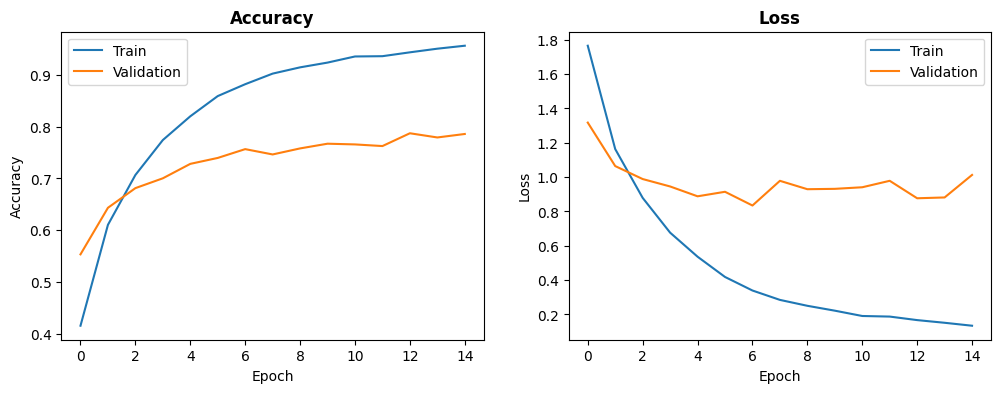

In [16]:
# Biểu đồ Độ chính xác (Accuracy) và Độ mất mát (Loss) của tập Train và Val
acc = history_req.history.get('accuracy', [])
val_acc = history_req.history.get('val_accuracy', [])
loss = history_req.history.get('loss', [])
val_loss = history_req.history.get('val_loss', [])

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(acc, label='Train')
ax[0].plot(val_acc, label='Validation')
ax[0].set_title('Accuracy', fontweight='bold')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(loss, label='Train')
ax[1].plot(val_loss, label='Validation')
ax[1].set_title('Loss', fontweight='bold')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
plt.show()

#model_req.summary()

In [18]:
# Đánh giá mô hình trên tập Val
print("Đánh giá mô hình trên tập Val...")
val_loss, val_accuracy = model_req.evaluate(val_ds_req, verbose=1)
print(f"\nĐộ mất mát trên tập Val: {val_loss:.4f}")
print(f"Độ chính xác trên tập Val: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")

Đánh giá mô hình trên tập Val...
158/158 ━━━━━━━━━━━━━━━━━━━━ 17s 109ms/step - accuracy: 0.7861 - loss: 1.0126

Độ mất mát trên tập Val: 1.0126
Độ chính xác trên tập Val: 0.7861 (78.61%)


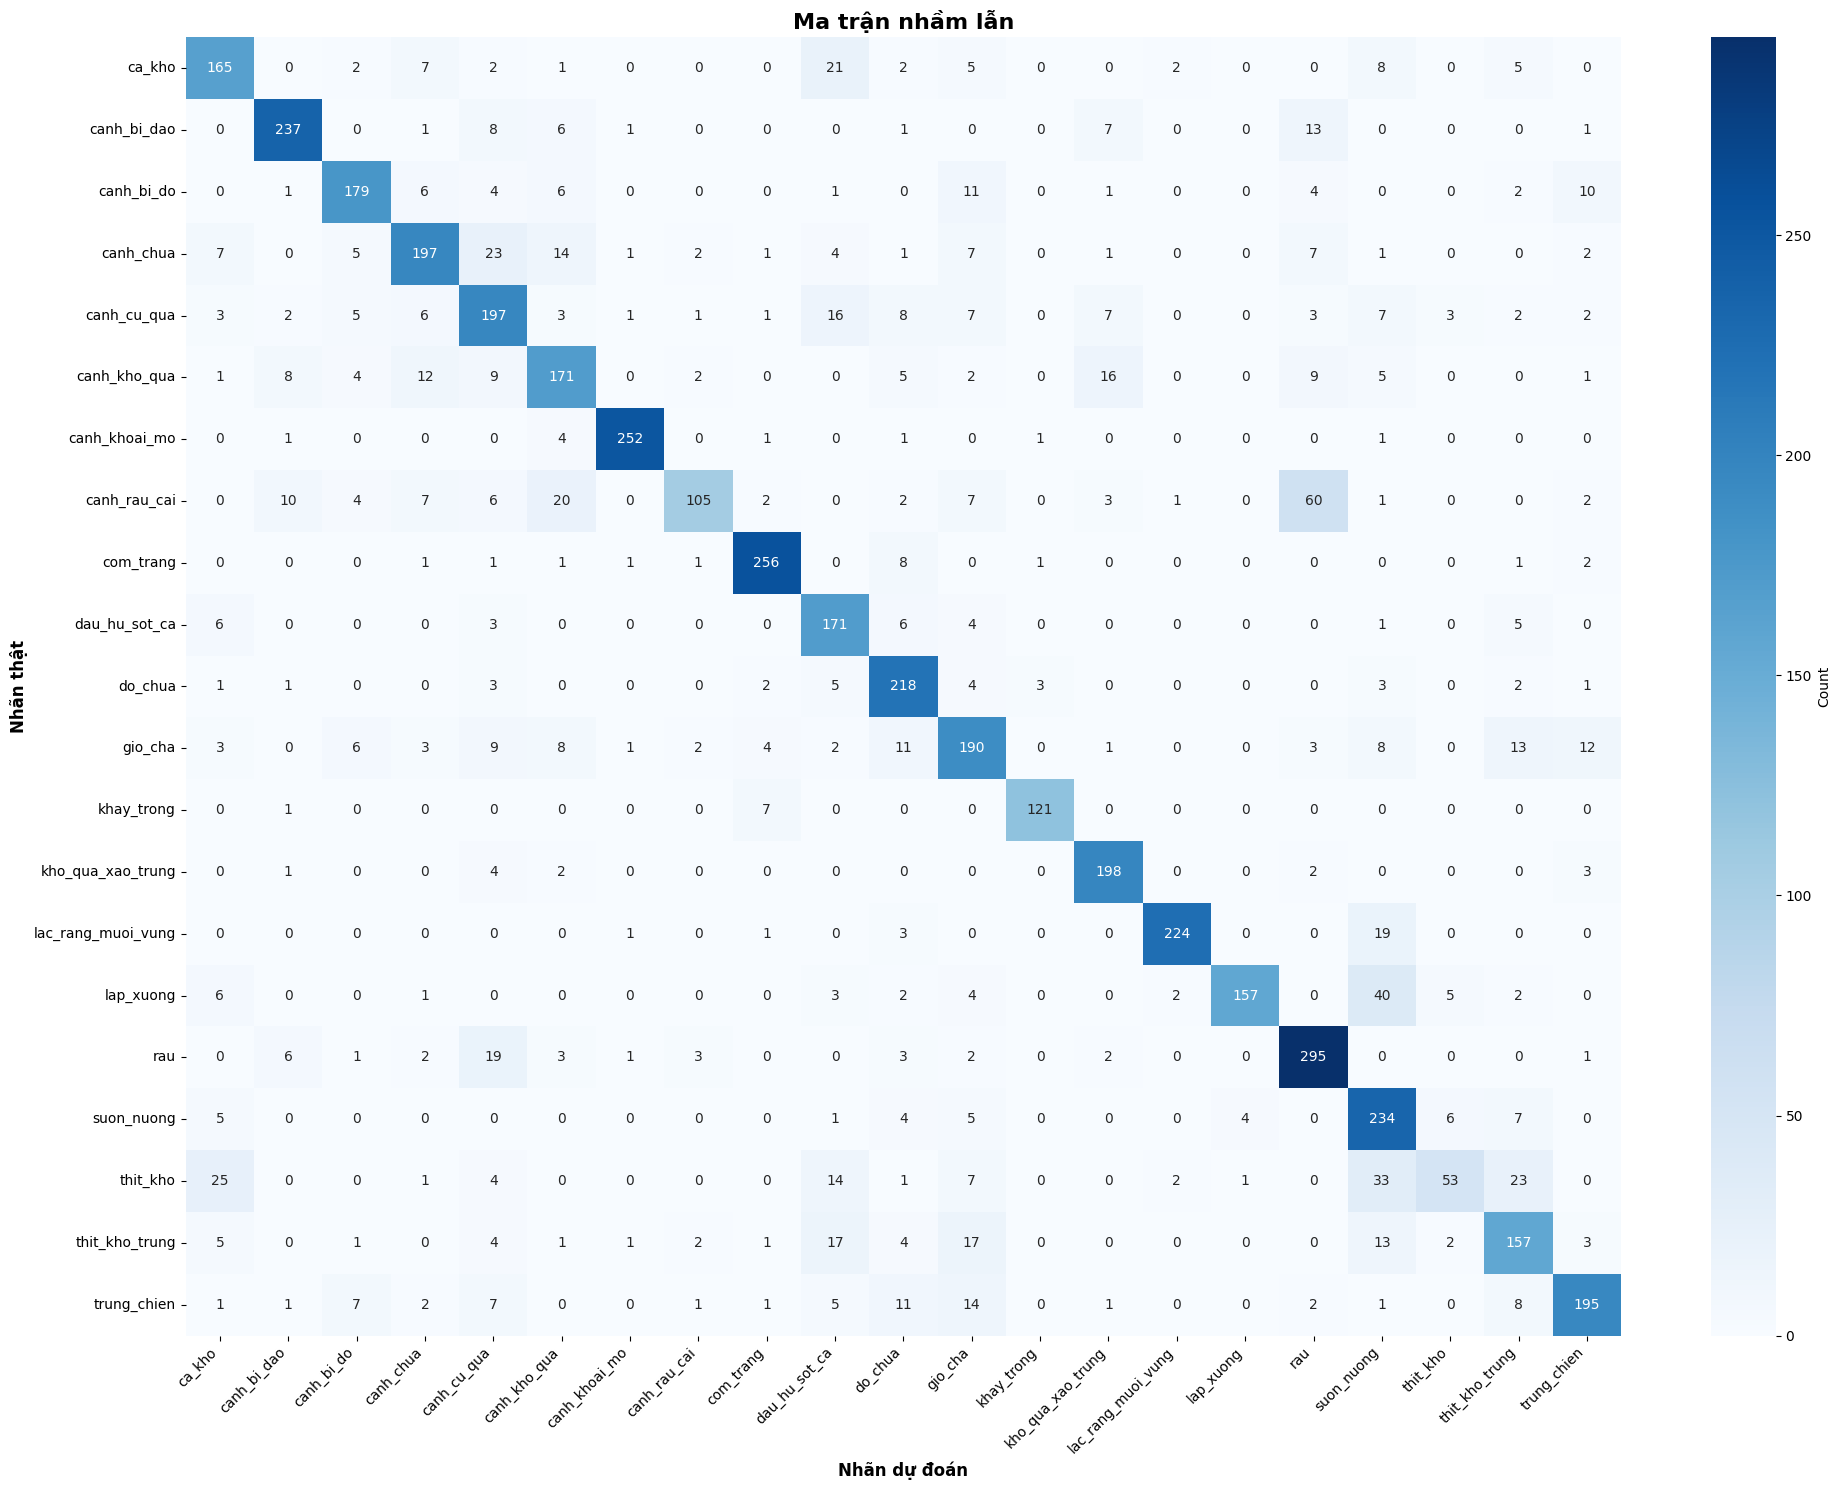

In [19]:
# Biểu đồ Ma trận nhầm lẫn (Confusion matrix)
y_true = []
y_pred = []

for images, labels in val_ds_req:
    predictions = model_req.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(20, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names_req, yticklabels=class_names_req, cbar_kws={'label': 'Count'})
plt.title('Ma trận nhầm lẫn', fontsize=16, fontweight='bold')
plt.xlabel('Nhãn dự đoán', fontsize=12, fontweight='bold')
plt.ylabel('Nhãn thật', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [23]:
# Báo cáo đánh giá mô hình
print("-"*60)
print("               BÁO CÁO ĐÁNH GIÁ MÔ HÌNH")
print("-"*60)
print(classification_report(y_true, y_pred, target_names=class_names_req, digits=4))

------------------------------------------------------------
               BÁO CÁO ĐÁNH GIÁ MÔ HÌNH
------------------------------------------------------------
                    precision    recall  f1-score   support

            ca_kho     0.7237    0.7500    0.7366       220
       canh_bi_dao     0.8810    0.8618    0.8713       275
        canh_bi_do     0.8364    0.7956    0.8155       225
         canh_chua     0.8008    0.7216    0.7592       273
       canh_cu_qua     0.6502    0.7190    0.6828       274
      canh_kho_qua     0.7125    0.6980    0.7052       245
     canh_khoai_mo     0.9692    0.9655    0.9674       261
      canh_rau_cai     0.8824    0.4565    0.6017       230
         com_trang     0.9242    0.9377    0.9309       273
     dau_hu_sot_ca     0.6577    0.8724    0.7500       196
           do_chua     0.7491    0.8971    0.8165       243
           gio_cha     0.6643    0.6884    0.6762       276
        khay_trong     0.9603    0.9380    0.9490       1

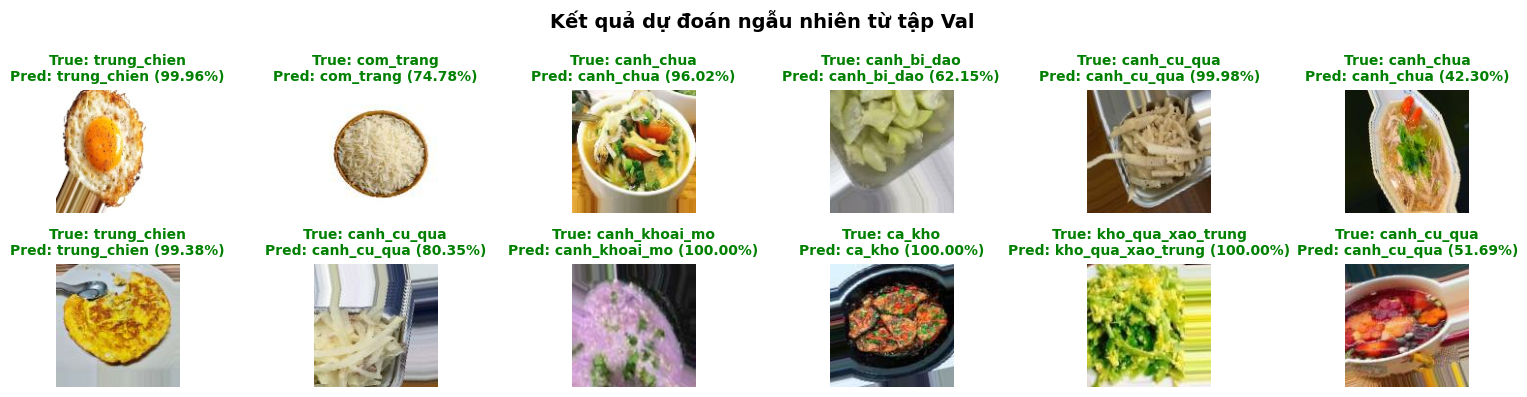

In [27]:
# Dự đoán với ảnh ngẫu nhiên từ tập Val
def predict_image(model, image, class_names):
    '''Dự đoán lớp của một ảnh'''
    # Thêm chiều batch để phù hợp với định dạng đầu vào của mô hình
    img_array = tf.expand_dims(image, 0)
    # Thực hiện dự đoán và lấy top 3 dự đoán có xác suất cao nhất
    predictions = model.predict(img_array, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_idx]
    predicted_class = class_names[predicted_class_idx]

    top3_indices = np.argsort(predictions[0])[-3:][::-1]
    top3_predictions = [(class_names[i], predictions[0][i]) for i in top3_indices]
    
    return predicted_class, confidence, top3_predictions

# Lấy một batch ảnh từ tập Val và chọn 12 ảnh ngẫu nhiên
test_images, test_labels = next(iter(val_ds_req))
num_test_images = min(12, len(test_images))
indices = random.sample(range(len(test_images)), num_test_images)

fig, axes = plt.subplots(2, 6, figsize=(16, 4))
axes = axes.flatten()

# Vòng lặp dự đoán các ảnh được chọn
for i, idx in enumerate(indices):
    image = test_images[idx]
    true_label_idx = test_labels[idx].numpy()
    true_label = class_names_req[true_label_idx]
    
    pred_class, confidence, top3 = predict_image(model_req, image, class_names_req)
    
    # Trực quan hóa kết quả dự đoán
    axes[i].imshow(image.numpy().astype('uint8'))
    color = 'green' if pred_class == true_label else 'red'
    title = f"True: {true_label}\nPred: {pred_class} ({confidence:.2%})"
    axes[i].set_title(title, color=color, fontsize=10, fontweight='bold')
    axes[i].axis('off')

plt.suptitle("Kết quả dự đoán ngẫu nhiên từ tập Val", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

------------------------------------------------------------
         Kết quả dự đoán một hình ảnh ngẫu nhiên
------------------------------------------------------------

Đường dẫn hình ảnh: D:/IR_challenge/data_test/timg (7).jpg
Top 5 dự đoán:
  1. canh_chua           : 100.00%
  2. canh_bi_do          : 0.00%
  3. ca_kho              : 0.00%
  4. rau                 : 0.00%
  5. dau_hu_sot_ca       : 0.00%


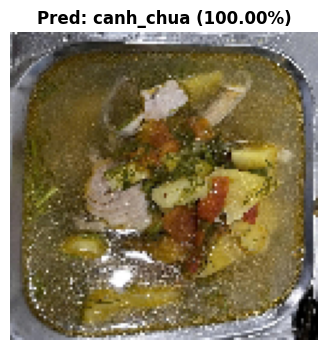

In [ ]:
# Dự đoán với ảnh bất kỳ từ hệ thống
def test_single_image(image_path, model, class_names, img_size=(128, 128)):
    '''Dự đoán lớp của một ảnh bất kỳ'''
    # Tiền xử lý ảnh
    img = tf.keras.utils.load_img(image_path, target_size=img_size)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)     # Thêm chiều batch

    # Thực hiện dự đoán và lấy top 5 dự đoán có xác suất cao nhất
    predictions = model.predict(img_array, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_idx]
    predicted_class = class_names[predicted_class_idx]

    top5_indices = np.argsort(predictions[0])[-5:][::-1]
    top5_predictions = [(class_names[i], predictions[0][i]) for i in top5_indices]
    
    # Trực quan hóa kết quả
    plt.figure(figsize=(5, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Pred: {predicted_class} ({confidence:.2%})', fontsize=12, fontweight='bold')
    print(f"\nĐường dẫn hình ảnh: {image_path}")
    print(f"Top 5 dự đoán:")
    for i, (cls, conf) in enumerate(top5_predictions, 1):
        print(f"  {i}. {cls:20s}: {conf:.2%}")
    plt.show()
    
    return predicted_class, confidence, top5_predictions

print("-"*60)
print("         Kết quả dự đoán một hình ảnh ngẫu nhiên")
print("-"*60)

test_single_image('D:/IR_challenge/data_test/timg (7).jpg', model_req, class_names_req, IMG_SIZE);

In [44]:
# Lưu lại mô hình CNN và tên lớp đã huấn luyện
model_save_path = Path.cwd().parent / 'models' / 'cnn_food_classifier.h5'
model_save_path.parent.mkdir(parents=True, exist_ok=True)

model_req.save(str(model_save_path))
print(f"Lưu model tại: {model_save_path}")

import json
class_names_path = model_save_path.parent / 'class_names.json'
with open(class_names_path, 'w', encoding='utf-8') as f:
    json.dump(class_names_req, f, ensure_ascii=False, indent=2)
print(f"Lưu class names tại: {class_names_path}")

Lưu model tại: d:\IR_challenge\models\cnn_food_classifier.h5
Lưu class names tại: d:\IR_challenge\models\class_names.json
